In [1]:
# Mapas nacionales y subnacionales.

import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

import geopandas as gpd

In [2]:
# Datos

# Carpetas
path_catalog = "../../Bases_de_datos/Data_catalog.csv"
path_v = "../data/variables.csv"
map_d = "../../Bases_de_datos/Mapas/"
data_d = "../results/"
wb_path = "../../Bases_de_datos/World_Bank_CCKP/"

# Mapas
map_f = [ "Natural_Earth/ne_50m_admin_0_countries",
    "Natural_Earth/ne_10m_admin_0_countries",
    "Natural_Earth/ne_10m_admin_1_states_provinces",
    "Natural_Earth/ne_10m_admin_1_states_provinces_mod",
    "OECD/OECD_TL2_shapefile",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_RUSSIA_CHINA_INDIA.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_BRAZIL.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_COLOMBIA.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_PERU.shp",
    "OECD/Shape_TL2_Non_OECD/TL2_OECD_2016_SOUTH_AFRICA.shp" ]

# Datos OCDE
data_f = [ "Deciles_climate.csv", "Deciles_governance.csv",
    "Deciles_socioeconomic.csv", "countries_values_net_zero.csv",
    "Values_climate.csv", "Values_governance.csv",
    "Values_socioeconomic.csv" ]

# Códigos nacionales y subnacionales
ix  = "alpha-3"
ix1 = "iso_3166_2" 

# Relación de códigos Banco Mundial y Natural Earth (ISO 3166-2)
code_path = "../../Bases_de_datos/Subnational_Code_WB_ISO.csv"

# Catálogo de datos
df_c = pd.read_csv(path_catalog)
# Variables utilizadas para el índicador de resiliencia
df_v = pd.read_csv(path_v)

# Mapas
gdf0_50 = gpd.read_file( map_d + map_f[0] ).rename(
    columns = {"GU_A3": ix} ).set_index( ix )
gdf0_10 = gpd.read_file( map_d + map_f[1] ).rename( 
    columns = {"GU_A3": ix1} ).set_index( ix1 )
gdf1_50 = gpd.read_file( map_d + map_f[2] ).set_index( ix1 )
gdf1_mod = gpd.read_file( map_d + map_f[3] ).set_index( ix1 )

# Datos a graficar
df_1   = pd.read_csv( data_d + data_f[3], index_col = ix )
df_2 = pd.read_csv( data_d + data_f[0], index_col = ix )
df_3 = pd.read_csv( data_d + data_f[4], index_col = ix )

# Unimos los datos y el mapa
gdf_2 = gdf0_50.merge(df_1, how = "left",
    left_index = True, right_index = True )
gdf_3 = gdf_2.merge( df_2, how = "left",
    left_index = True, right_index = True )
gdf_4 = gdf_2.merge( df_3, how = "left",
    left_index = True, right_index = True )

In [3]:
# Cargamos los datos del World Bank y los unimos a un mapa
# Number of hot days per year above 35°C, 1995-2014

# Variable a estudiar
v = "h35_hist"
# Número de archivo correspondiente
i = 1 # Histórico

# Lista de archivos del World Bank
wb_f = os.listdir(wb_path)
# Los datos se descargan en un Excel
wb_h = pd.read_excel(wb_path + wb_f[i], index_col = "code" )
# Cargamos la relación de códigos.
code_wb = pd.read_csv(code_path, index_col = "code" )
# Usamos solo los datos de los códigos de la relación
# Quitamos datos subnacionales que no tenemos
wb_h = wb_h.loc[ code_wb.index ]

# Agregamos código, país, y nombre según Natural Earth
wb_h[ix1] = code_wb[ix1]
wb_h["country"] = code_wb["adm0_a3"]
wb_h["name"] = code_wb["name_N_E"]

# Cambiamos el código de Banco Mundial a ISO
wb_h = wb_h.reset_index(drop = True).set_index(ix1)
# Cambiamos nombre de columnas
wb_h.columns = ["name", v, ix]
# Si hay varias entradas del Banco Mundial por una de Natural Earth,
# hay que promediar. Debería hacerse ponderando las áreas de las regiones
# pero en algunos casos es muy difícil de obtener esa información
values = wb_h[v].groupby("iso_3166_2").mean()
wb_h = wb_h[ ~wb_h.index.duplicated(keep = "first") ].sort_index()

# Escogemos las geometrías subnacionales y nacionales que correspondan
sub_iso0 = wb_h[ ~wb_h.index.isin(gdf1_mod.index) ].index
sub_iso1 = wb_h[ wb_h.index.isin(gdf1_mod.index) ].index
gdf_sub_iso0 = gdf0_10[ gdf0_10.index.isin(sub_iso0) ][
    ["NAME", "geometry"] ].rename( columns = {"NAME": "name"} )
gdf_sub_iso1 = gdf1_mod[ gdf1_mod.index.isin(sub_iso1) ][["name", "geometry"]]
gdf_sub = pd.concat( [gdf_sub_iso0, gdf_sub_iso1] )

# Unimos las geometrías y los datos. Si hay un dato de World Bank para
# varios de Natural Earth se asigna el mismo valor a todas las geometrías
gdf_sub = gdf_sub.join(wb_h[v])

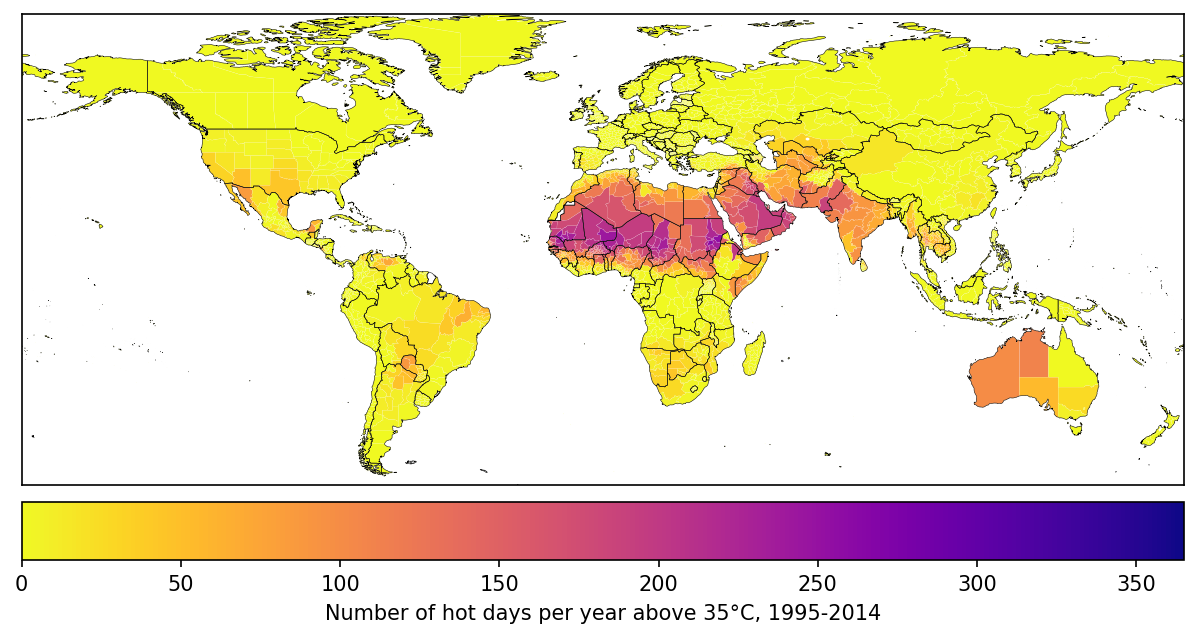

In [4]:
# Gráfica subnacional de Banco Mundial.
# Number of hot days per year above 35°C, 1995-2014

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Graficamos datos
gdf_sub.plot( ax = ax, column = v,  edgecolor = "white", linewidth = 0.05,
    cmap = "plasma_r", legend = True,
    vmin = 0, vmax = 365,
    #vmin = np.floor( gdf_sub[v].min() ), vmax = np.ceil( gdf_sub[v].max() ),
    legend_kwds = {
    "label": "Number of hot days per year above 35°C, 1995-2014",
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"}
    )

# Graficamos países
gdf0_50[ ~(gdf0_50.index == "ATA") ].boundary.plot(
    ax = ax, edgecolor = "black", linewidth = 0.25)

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

In [5]:
# Cargamos los datos del World Bank y los unimos a un mapa
# Number of hot days per year above 35°C, 2080-2099, RCP8.5

# Variable a estudiar
v = "h35_2090_rcp85"
# Número de archivo correspondiente
i = 0 # Histórico

# Lista de archivos del World Bank
wb_f = os.listdir(wb_path)
# Los datos se descargan en un Excel
wb_h = pd.read_excel(wb_path + wb_f[i], index_col = "code" )
# Cargamos la relación de códigos.
code_wb = pd.read_csv(code_path, index_col = "code" )
# Usamos solo los datos de los códigos de la relación
# Quitamos datos subnacionales que no tenemos
wb_h = wb_h.loc[ code_wb.index ]

# Agregamos código, país, y nombre según Natural Earth
wb_h[ix1] = code_wb[ix1]
wb_h["country"] = code_wb["adm0_a3"]
wb_h["name"] = code_wb["name_N_E"]

# Cambiamos el código de Banco Mundial a ISO
wb_h = wb_h.reset_index(drop = True).set_index(ix1)
# Cambiamos nombre de columnas
wb_h.columns = ["name", v, ix]
# Si hay varias entradas del Banco Mundial por una de Natural Earth,
# hay que promediar. Debería hacerse ponderando las áreas de las regiones
# pero en algunos casos es muy difícil de obtener esa información
values = wb_h[v].groupby("iso_3166_2").mean()
wb_h = wb_h[ ~wb_h.index.duplicated(keep = "first") ].sort_index()

# Escogemos las geometrías subnacionales y nacionales que correspondan
sub_iso0 = wb_h[ ~wb_h.index.isin(gdf1_mod.index) ].index
sub_iso1 = wb_h[ wb_h.index.isin(gdf1_mod.index) ].index
gdf_sub_iso0 = gdf0_10[ gdf0_10.index.isin(sub_iso0) ][
    ["NAME", "geometry"] ].rename( columns = {"NAME": "name"} )
gdf_sub_iso1 = gdf1_mod[ gdf1_mod.index.isin(sub_iso1) ][["name", "geometry"]]
gdf_sub = pd.concat( [gdf_sub_iso0, gdf_sub_iso1] )

# Unimos las geometrías y los datos. Si hay un dato de World Bank para
# varios de Natural Earth se asigna el mismo valor a todas las geometrías
gdf_sub = gdf_sub.join(wb_h[v])

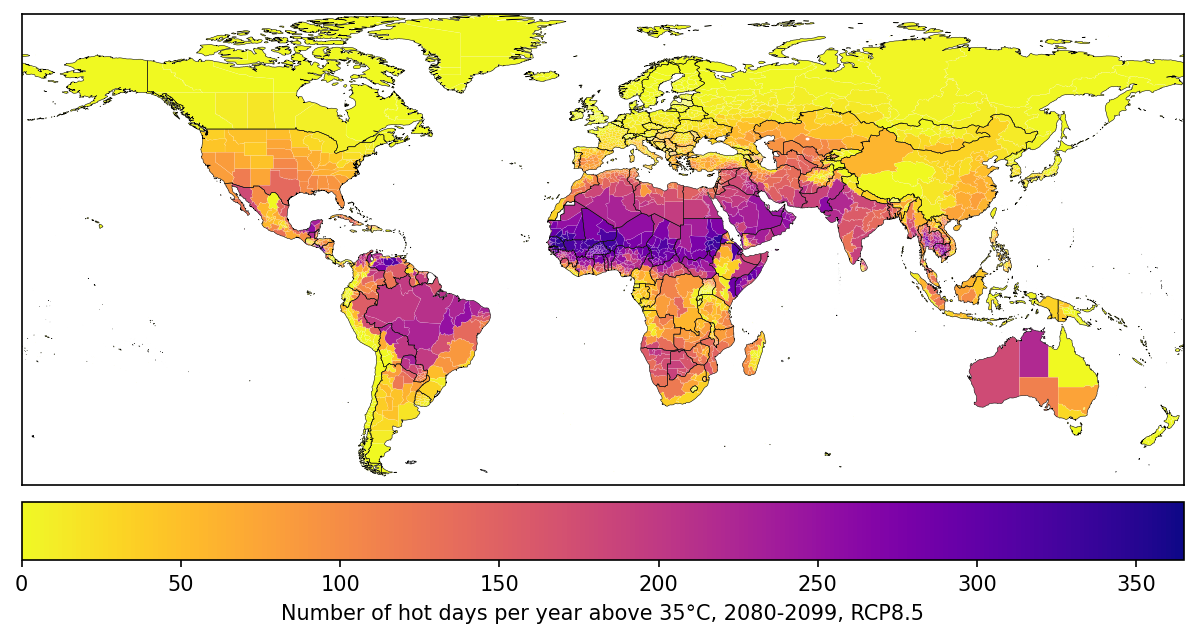

In [6]:
# Gráfica subnacional de Banco Mundial.
# Number of hot days per year above 35°C, 2080-2099, RCP8.5

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Graficamos datos
gdf_sub.plot( ax = ax, column = v,  edgecolor = "white", linewidth = 0.05,
    cmap = "plasma_r", legend = True,
    vmin = 0, vmax = 365,
    #vmin = np.floor( gdf_sub[v].min() ), vmax = np.ceil( gdf_sub[v].max() ),
    legend_kwds = {
    "label": "Number of hot days per year above 35°C, 2080-2099, RCP8.5",
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"}
    )

# Graficamos países
gdf0_50[ ~(gdf0_50.index == "ATA") ].boundary.plot(
    ax = ax, edgecolor = "black", linewidth = 0.25)

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

In [7]:
# Unimos los vectores de la OECD

# Vectores subnacionales OECD
gdf_oe = gpd.read_file(map_d + map_f[4] ).rename(
    columns = {"iso3": ix, "tl2_id": "REF_AREA", "name_en": "NAME"}
    ).set_index("REF_AREA")[ [ix, "NAME", "geometry"] ]

# Archivos separados no OECD
gdf_noe = []
for f in map_f[5:]:
    gdf_noe.append( gpd.read_file(map_d + f).to_crs(4326))
gdf_noe[0] = gdf_noe[0].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe[1] = gdf_noe[1].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe[3] = gdf_noe[3].rename( columns = {"TL_CODE": "REF_AREA",
    "TL_NAME": "NAME", "COUNTRY": ix} ).set_index("REF_AREA")
gdf_noe[4] = gdf_noe[4].rename( columns = {"CODE": "REF_AREA",
    "COUNTRY": ix} ).set_index("REF_AREA")
# Unimos los archivos
gdf_noe = pd.concat( gdf_noe[0:2] + gdf_noe[3:] )[
    [ix, "NAME", "geometry"] ]

# Unimos todos los vectores subnacionales
gdf_oecd = pd.concat( [gdf_oe, gdf_noe] )

# Agregamos los vectores nacionales que no tienen datos subnacionales
gdf_countries = gdf0_50.loc[ ~gdf0_50.index.isin(gdf_oecd[ix].unique()),
    ["NAME", "geometry"] ]
gdf_countries.index = gdf_countries.index.rename("REF_AREA")
gdf_countries[ix] = gdf_countries.index
gdf_oecd = pd.concat( [gdf_oecd, gdf_countries] )

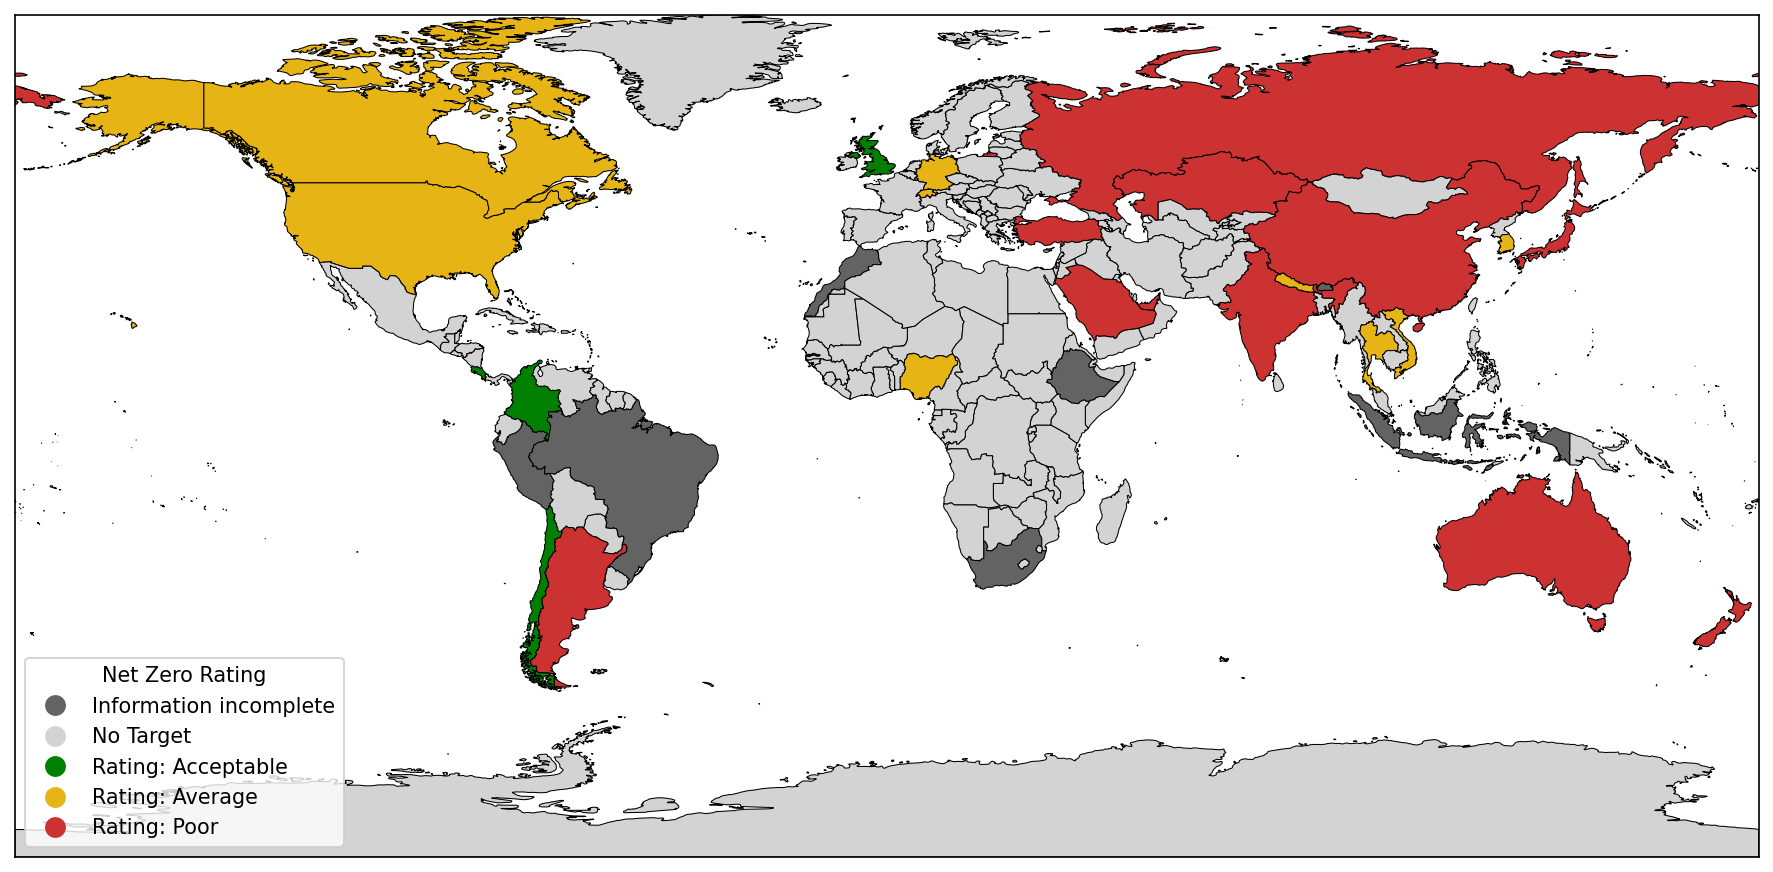

In [8]:
# Gráfica de Climate Action Tracker Net Zero Rating

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(15, 10)
fig.set_dpi(150) 

# Cambiamos los nombres para que estén ordenados alfabéticamente.
gdf_2["Net Zero Rating"] = gdf_2["Net Zero Rating"].fillna( "No Target"
    ).replace( { "Acceptable": "Rating: Acceptable",
    "Average": "Rating: Average", "Poor": "Rating: Poor" } )

# Establecemos los colores 
color_dict = { "Information incomplete": "#636363", "No Target": "lightgrey",
    "Rating: Acceptable": "green", "Rating: Average": "#e7b416",
    "Rating: Poor": "#cc3232", 
  }

# Graficamos Net Zero Rating
gdf_2.plot( ax = ax, column = gdf_2["Net Zero Rating"],
    cmap = colors.ListedColormap(list(color_dict.values())),
    edgecolor = "black", linewidth = 0.5, legend = True,
    legend_kwds = {"title": "Net Zero Rating", "loc": "lower left"} ) 

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

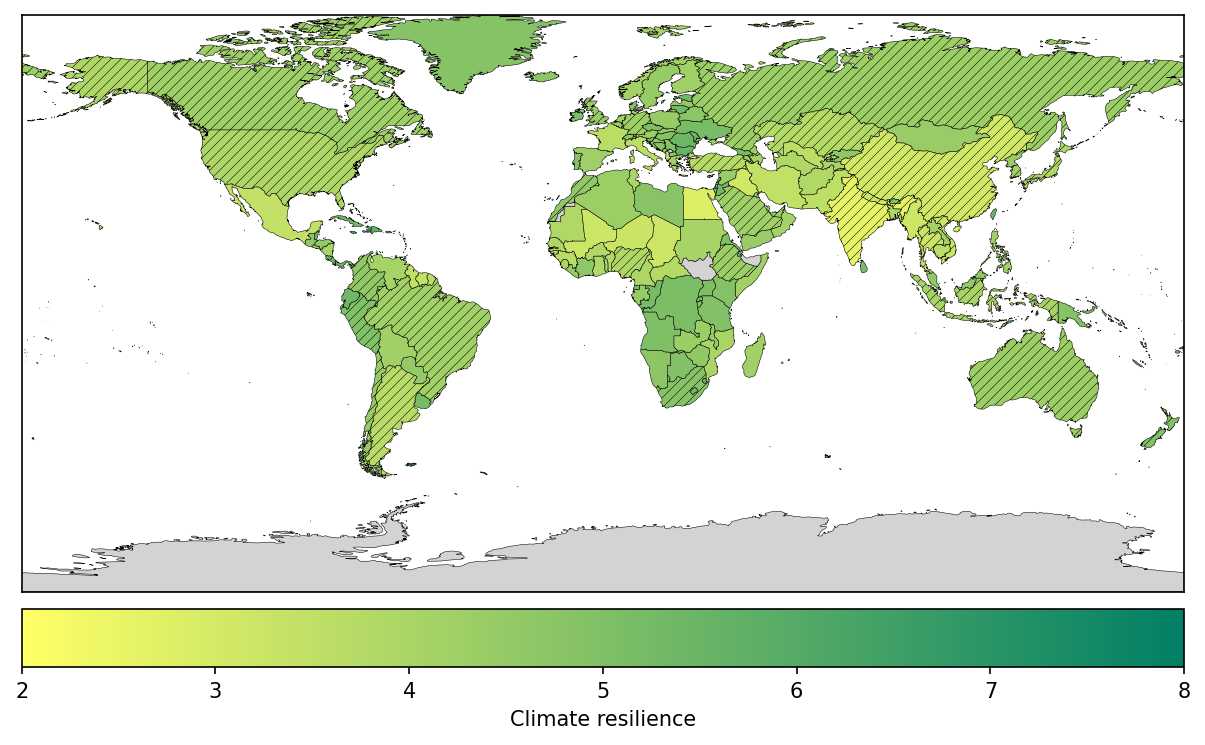

In [9]:
# Gráfica de índice de resiliencia climática

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Ajustes de achurado
plt.rcParams["hatch.linewidth"] = 0.25

# Graficamos índice de resiliencia climática
gdf_3.plot( ax = ax, column = "Mean",  edgecolor = "black", linewidth = 0.25,
    cmap = "summer_r", legend = True,
    vmin = np.floor( gdf_3["Mean"].min() ),
    vmax = np.ceil( gdf_3["Mean"].max() ),
    legend_kwds = {"label": "Climate resilience",
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

# Garficamos países con objetivo Net Zero
gdf_3[ ~gdf_3["Net Zero Rating"].isnull() ].plot( ax = ax,
    edgecolor = "black", color = "none",
    hatch = "/////", linewidth = 0 )

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

In [10]:
# Cargamos datos de variable climática

# Base de datos y variable a usar
id = "EXT_TEMP"
v = "HD_POP_EXP"
dur = df_v.loc[df_v["Variable"] == v , "DURATION"].iloc[0]

# Cargamos el archivo
df = pd.read_csv( "../../" + df_c.loc[df_c["ID"] == id, "Path"].iloc[0]
    + df_c.loc[df_c["ID"] == id, "Filename"].iloc[0])

# Escogemos el tiempo y medida de interés
df_i = df[ (df["MEASURE"] == v) & (df["DURATION"] == dur) ]
df_i = df_i.sort_values( ["REF_AREA", "TIME_PERIOD"]
    ).drop_duplicates("REF_AREA", keep = "last").set_index("REF_AREA")

# Lo unimos a los datos geográficos
gdf_sub = gdf_oecd.merge(df_i, how = "left",
    left_index = True, right_index = True )

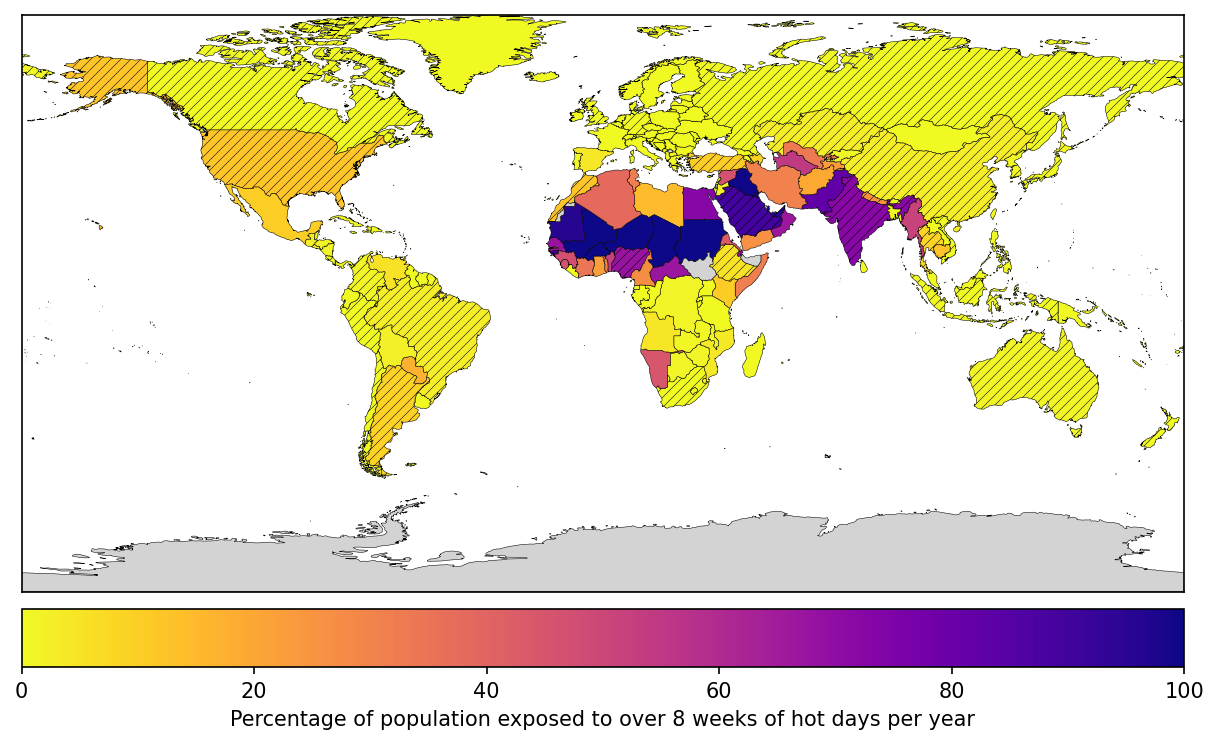

In [11]:
# Percentage of population exposed to over 8 weeks of hot days per year
# Nacional

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Ajustes de achurado
plt.rcParams["hatch.linewidth"] = 0.25

# Variable a graficar
name = "Percentage of population exposed to over 8 weeks of hot days per year"
v = "HD_POP_EXP"

# Graficamos variable climática
gdf_4.plot( ax = ax, column = v,  edgecolor = "black", linewidth = 0.25,
    cmap = "plasma_r", legend = True,
    vmin = np.floor( gdf_4[v].min() ), vmax = np.ceil( gdf_4[v].max() ),
    legend_kwds = {"label": name,
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

# Garficamos países con objetivo Net Zero
gdf_4[ ~gdf_4["Net Zero Rating"].isnull() ].plot( ax = ax,
    edgecolor = "black", color = "none",
    hatch = "/////", linewidth = 0 )

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()

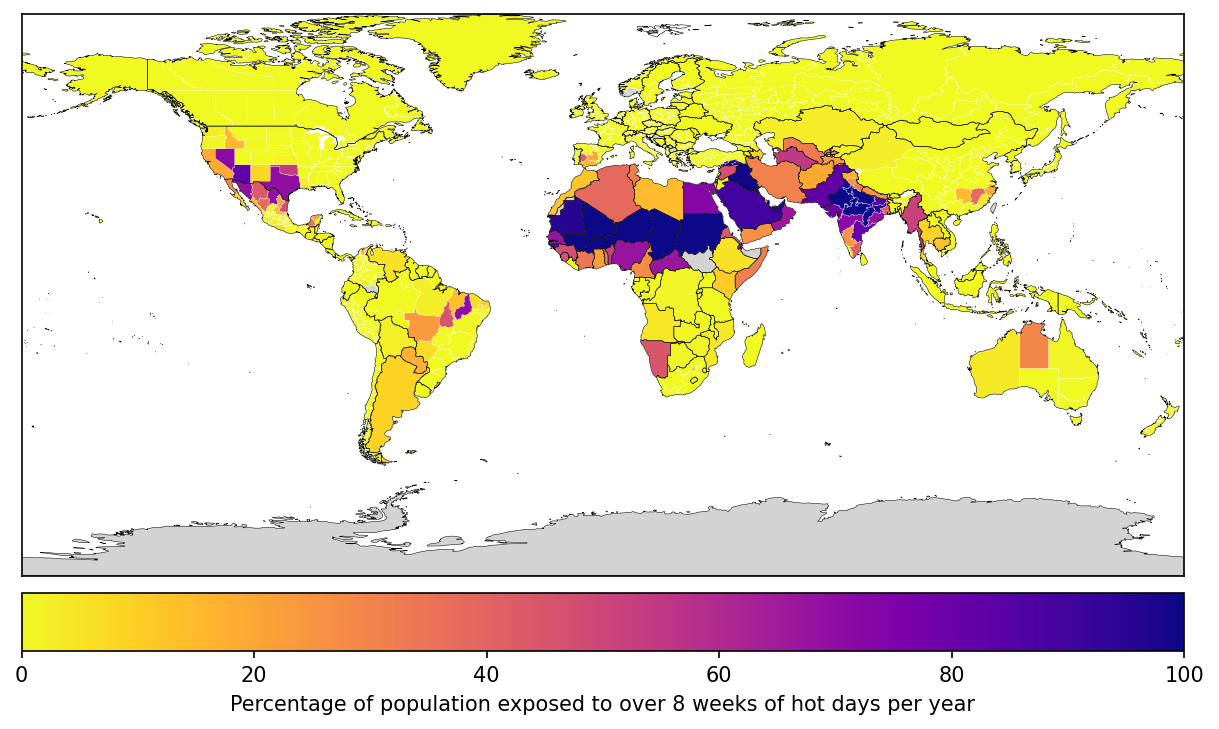

In [12]:
# Percentage of population exposed to over 8 weeks of hot days per year
# Subnacional

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150) 

# Variable a graficar
name = "Percentage of population exposed to over 8 weeks of hot days per year"
v = "OBS_VALUE"

# Graficamos variable climática
gdf_sub.plot( ax = ax, column = v,  edgecolor = "white", linewidth = 0.1,
    cmap = "plasma_r", legend = True,
    vmin = np.floor( gdf_sub[v].min() ), vmax = np.ceil( gdf_sub[v].max() ),
    legend_kwds = {"label": name,
    "orientation": "horizontal", "pad":  0.01 },
    missing_kwds = {"color": "lightgrey"} )

# Graficamos fronteras nacionales
gdf0_50.boundary.plot(ax = ax, edgecolor = "black", linewidth = 0.25)

# Ajustes de visualización
#ax.axis('off')
ax.margins(0)
ax.tick_params( left = False, labelleft = False,
    bottom = False, labelbottom = False )

plt.show()